## Peniel Maame Akyireko Ansah
### Final Project : `Stroke Prediction Convolutional Nueural Network`

# Imports

In [3]:
import os
import cv2
import imghdr
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
import psutil

C:\Users\user\AppData\Local\Temp\ipykernel_45080\969120991.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# Data cleaning and preparation

In [5]:
def clean_dataset(dataset_dir, valid_extensions):
    """Removes files with invalid extensions from the dataset."""
    
    # Loop through each class in the dataset directory
    for image_class in os.listdir(dataset_dir):
        
        # Loop through each image file in the current class folder
        for image_file in os.listdir(os.path.join(dataset_dir, image_class)):
            
            # Create the full path for the image file
            image_path = os.path.join(dataset_dir, image_class, image_file)
            
            try:
                # Try to read the image using OpenCV (cv2)
                img = cv2.imread(image_path)
                
                # Get the image file's format/extension (like jpg, png)
                img_ext = imghdr.what(image_path)
                
                # Check if the image extension is valid
                if img_ext not in valid_extensions:
                    # If the extension is not valid, remove the image file
                    print(f'Removing invalid image: {image_path}')
                    os.remove(image_path)
            except Exception as e:
                # If there is an error, print the error message
                print(f'Error processing image {image_path}: {e}')

In [6]:
def prepare_data(dataset_dir):
    """Prepares and normalizes the dataset."""
    
    # Load images from the directory, automatically labeling based on folder names.
    # Normalize the pixel values to be between 0 and 1 by dividing by 255.
    return tf.keras.utils.image_dataset_from_directory(dataset_dir).map(
        lambda x, y: (x / 255, y)  # Normalize images
    )

# SPlit data into Train, Test and Validation

In [8]:
def split_data(dataset, train_ratio, val_ratio):
    """Splits the dataset into training, validation, and testing sets."""
    
    # Calculate the number of samples for each set
    total_size = len(dataset)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size

    # Split the dataset into train, validation, and test sets
    train_data = dataset.take(train_size)
    val_data = dataset.skip(train_size).take(val_size)
    test_data = dataset.skip(train_size + val_size).take(test_size)

    # Return the split datasets
    return train_data, val_data, test_data

# build Model

In [10]:
def build_model(input_shape):
    """Builds the convolutional neural network model."""
    
    # Create a sequential model with layers
    model = Sequential([
        # First convolutional layer with 16 filters and 3x3 kernel size
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(),  # Max pooling layer to reduce size
        
        # Second convolutional layer with 32 filters
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(),  # Max pooling layer
        
        # Third convolutional layer with 16 filters
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(),  # Max pooling layer
        
        Flatten(),  # Flatten the output to a 1D vector
        
        # Fully connected layer with 256 units
        Dense(256, activation='relu'),
        
        # Output layer with 1 unit (binary classification)
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with Adam optimizer and binary crossentropy loss
    model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
    
    return model

# Visualise data

In [12]:
def visualize_data_samples(dataset):
    """Visualizes a few samples from the dataset."""
    
    # Convert the dataset into a numpy iterator to fetch data
    data_iterator = dataset.as_numpy_iterator()
    
    # Get the next batch of data (images and labels)
    batch = data_iterator.next()

    # Create a figure with 4 subplots to display images
    fig, axes = plt.subplots(ncols=4, figsize=(20, 20))
    
    # Loop through the first 4 images in the batch
    for idx, img in enumerate(batch[0][:4]):
        axes[idx].imshow(img)  # Display the image
        axes[idx].set_title(batch[1][idx])  # Set the title as the label
    plt.show()  # Show the plot

# Train model

In [14]:
def train_model(model, train_data, val_data, log_dir, epochs=20):
    """Trains the model and logs training metrics."""
    
    # Create a TensorBoard callback to log training metrics for visualization
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    
    # Train the model on the training data and validate it using validation data
    # Log training progress using TensorBoard
    history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=[tensorboard_callback])
    
    # Return the training history (loss, accuracy, etc.)
    return history

# Visualise Training history

In [16]:
def plot_training_history(history):
    """Plots training and validation metrics."""
    
    # Plot the loss during training and validation
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='Training Loss', color='red')  # Plot training loss
    ax.plot(history.history['val_loss'], label='Validation Loss', color='black')  # Plot validation loss
    ax.set_title('Loss')  # Set title of the plot
    ax.legend()  # Add legend
    plt.show()  # Show the plot

    # Plot the accuracy during training and validation
    fig, ax = plt.subplots()
    ax.plot(history.history['accuracy'], label='Training Accuracy', color='red')  # Plot training accuracy
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='black')  # Plot validation accuracy
    ax.set_title('Accuracy')  # Set title of the plot
    ax.legend()  # Add legend
    plt.show()  # Show the plot

# Evaluate Model

In [18]:
def evaluate_model(model, test_data):
    """Evaluates the model and computes performance metrics."""
    
    # Initialize metrics: Precision, Recall, and Accuracy
    precision = Precision()
    recall = Recall()
    accuracy = BinaryAccuracy()
    
    # Initialize a confusion matrix for binary classification (2x2)
    confusion_mat = np.zeros((2, 2))

    # Loop through the test data in batches
    for batch in test_data.as_numpy_iterator():
        x, y = batch  # x is input, y is actual label
        y_pred = model.predict(x)  # Get model predictions
        
        # Update the metrics with the current batch
        precision.update_state(y, y_pred)
        recall.update_state(y, y_pred)
        accuracy.update_state(y, y_pred)
        
        # Update the confusion matrix
        confusion_mat += confusion_matrix(y, y_pred.round())  # Round the predictions to 0 or 1

    # Print the calculated metrics
    print(f'Precision: {precision.result().numpy()}')
    print(f'Recall: {recall.result().numpy()}')
    print(f'Accuracy: {accuracy.result().numpy()}')

    # Convert confusion matrix values to integers for display
    confusion_mat = confusion_mat.astype(int)

    # Plot the confusion matrix as a heatmap
    sns.heatmap(confusion_mat, annot=True, fmt='d')  # 'd' for integers
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Predict Image

In [20]:
def predict_image(model, image_path):
    """Makes a prediction for a single image."""
    
    # Read the image from the given file path
    img = cv2.imread(image_path)
    
    # Resize the image to 256x256 pixels
    resized_img = tf.image.resize(img, (256, 256))
    
    # Make a prediction using the model (normalize image by dividing by 255)
    prediction = model.predict(np.expand_dims(resized_img / 255, 0))

    # Display the image
    plt.imshow(img)
    plt.show()

    # Print the predicted class based on the model's output
    if prediction > 0.5:
        print('Predicted class: Stroke')
    else:
        print('Predicted class: Normal')

# Baseline Algorithm

In [22]:
def baseline_algorithm(dataset):
    """Implements a baseline algorithm by always predicting the most common label."""
    
    # Create a list to store all the labels in the dataset
    labels = []
    
    # Loop through the dataset and collect all the labels
    for _, label in dataset.unbatch():
        labels.append(label.numpy())
    
    # Find the most common label (the label that appears most often)
    most_common_label = max(set(labels), key=labels.count)
    
    # Calculate the accuracy of the baseline model (predicting the most common label)
    baseline_accuracy = labels.count(most_common_label) / len(labels)
    
    # Print the baseline accuracy
    print(f"Baseline Accuracy (predicting most common label): {baseline_accuracy}")

# Stroke Prediction

In [24]:
# Define the path to the dataset folder
dataset_dir = 'Dataset'

# Specify the valid image file extensions that we will work with
valid_extensions = ['jpeg', 'jpg', 'bmp', 'png']

In [25]:
# Clean the dataset by removing images with invalid file extensions
clean_dataset(dataset_dir, valid_extensions)

In [26]:
# Prepare the dataset by loading and normalizing the images
dataset = prepare_data(dataset_dir)

# Split the dataset into training, validation, and testing sets
train_data, val_data, test_data = split_data(dataset, train_ratio=0.8, val_ratio=0.1)

Found 4829 files belonging to 2 classes.


In [27]:
# Run the baseline algorithm on the training data to predict the most common label
baseline_algorithm(train_data)

Baseline Accuracy (predicting most common label): 0.5484375


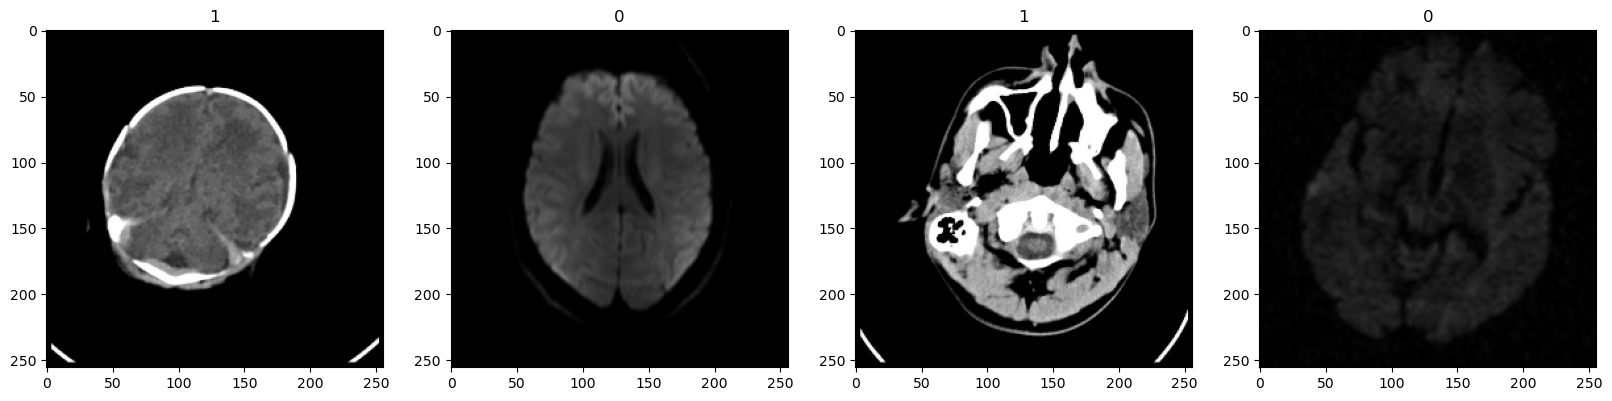

In [28]:
visualize_data_samples(train_data)

In [29]:
# Build the model with input shape of 256x256 pixels and 3 color channels (RGB)
model = build_model((256, 256, 3))

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Record the start time and memory usage before training the model
start_time = time.time()  # Capture the time before training starts
pid = os.getpid()  # Get the process ID of the current script
process = psutil.Process(pid)  # Create a process object for the current script
memory_before = process.memory_info().rss / (1024 * 1024)  # Get the memory usage in MB
print(f"Memory before training: {memory_before:.2f} MB")  # Print memory usage before training

# Start tracking memory usage during training
tracemalloc.start()  # Begin tracking memory usage

Memory before training: 871.74 MB


In [31]:
# Set the directory for logging training data
log_dir = 'logs'  # Directory where TensorBoard logs will be saved

# Train the model with the training and validation data
history = train_model(model, train_data, val_data, log_dir, epochs=20)  # Train the model for 20 epochs

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 48s 308ms/step - accuracy: 0.6135 - loss: 0.6497 - val_accuracy: 0.7750 - val_loss: 0.4694
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 352ms/step - accuracy: 0.7823 - loss: 0.4111 - val_accuracy: 0.8521 - val_loss: 0.3381
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 47s 391ms/step - accuracy: 0.8534 - loss: 0.2958 - val_accuracy: 0.8625 - val_loss: 0.3464
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 355ms/step - accuracy: 0.9084 - loss: 0.2182 - val_accuracy: 0.8792 - val_loss: 0.3085
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 45s 370ms/step - accuracy: 0.9273 - loss: 0.1722 - val_accuracy: 0.8854 - val_loss: 0.2930
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 359ms/step - accuracy: 0.9361 - loss: 0.1464 - val_accuracy: 0.9062 - val_loss: 0.3104
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 345ms/step - accuracy: 0.9648 - loss: 0.0975 - val_accuracy: 0.9250 - val_loss: 0.2920
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 79s 318ms/step - accuracy: 0.9749 - loss: 0

In [32]:
# Measure time taken for training
end_time = time.time()  # Get the current time after training
execution_time = end_time - start_time  # Calculate the total time taken
print(f"Execution Time: {execution_time:.4f} seconds")  # Print the time taken for training

# Measure memory after training using psutil
memory_after = process.memory_info().rss / (1024 * 1024)  # Get memory usage after training in MB
print(f"Memory after training: {memory_after:.2f} MB")  # Print memory usage after training

# Take a memory snapshot and analyze memory usage during the code
snapshot = tracemalloc.take_snapshot()  # Take a snapshot of memory usage
top_stats = snapshot.statistics('lineno')  # Get memory stats grouped by line number

print("\nTop memory-consuming lines:")  # Print the top lines consuming memory
for stat in top_stats[:10]:  # Show top 10 memory-consuming lines
    print(stat)

Execution Time: 906.6156 seconds
Memory after training: 1566.69 MB

Top memory-consuming lines:
C:\Users\user\anaconda3\Lib\linecache.py:137: size=1325 KiB, count=14262, average=95 B
C:\Users\user\anaconda3\Lib\site-packages\google\protobuf\internal\python_message.py:315: size=1100 KiB, count=1422, average=792 B
<frozen importlib._bootstrap_external>:753: size=943 KiB, count=7747, average=125 B
<frozen ntpath>:738: size=544 KiB, count=4729, average=118 B
<frozen ntpath>:66: size=544 KiB, count=4729, average=118 B
C:\Users\user\anaconda3\Lib\site-packages\tensorflow\python\framework\ops.py:266: size=527 KiB, count=7062, average=76 B
C:\Users\user\anaconda3\Lib\site-packages\google\protobuf\internal\python_message.py:154: size=451 KiB, count=2952, average=157 B
<frozen abc>:123: size=447 KiB, count=4401, average=104 B
C:\Users\user\anaconda3\Lib\site-packages\tensorflow\python\framework\ops.py:1247: size=373 KiB, count=1834, average=208 B
C:\Users\user\anaconda3\Lib\site-packages\google\

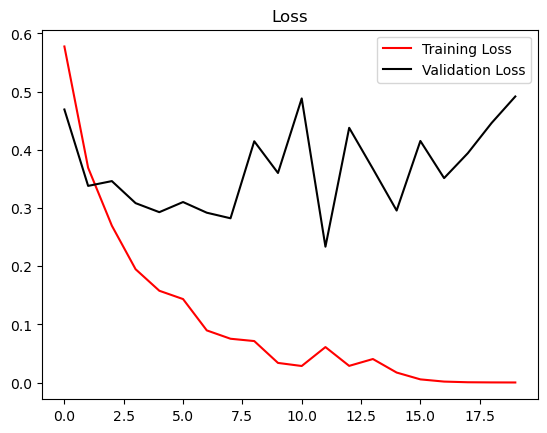

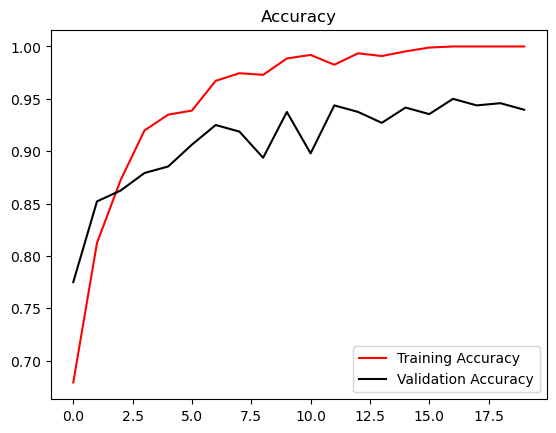

In [33]:
# Plot the training and validation loss and accuracy
plot_training_history(history)  # Calls the function to plot the training history

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Precision: 0.9074074029922485
Recall: 0.9074074029922485
Accuracy: 0.9214145541191101


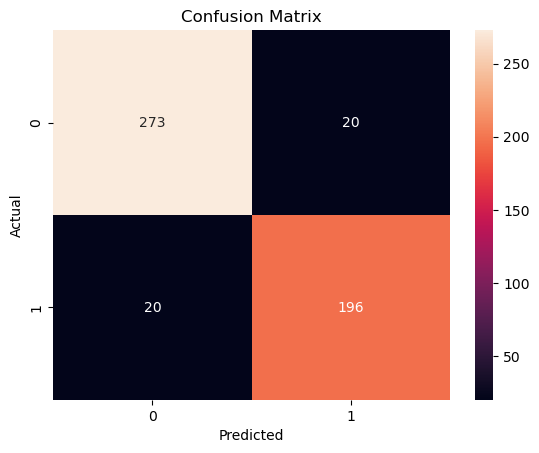

In [34]:
# Evaluate the model performance using test data
evaluate_model(model, test_data)  # Calls the function to evaluate the model on the test dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


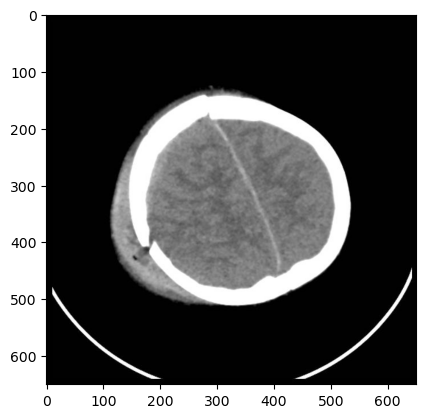

Predicted class: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


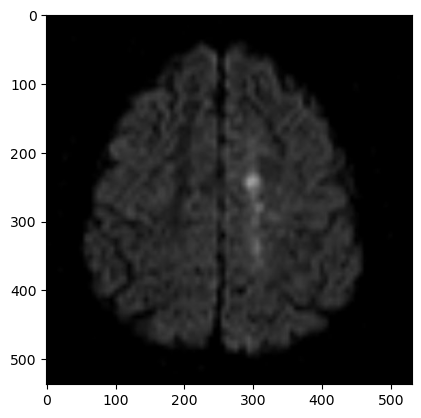

Predicted class: Stroke


In [35]:
# Make predictions for images in the 'Normal' and 'Stroke' categories
predict_image(model, 'Dataset/Normal/51 (42).jpg')  # Predict the class for a 'Normal' image
predict_image(model, 'Dataset/Stroke/2 (101).JPG')  # Predict the class for a 'Stroke' image

# Model Saving

In [37]:
# Save the trained model to a file
model.save('stroke_prediction_model.keras')  # Saves the model in Keras format for app use

UI link for prediction: https://stroke-predictionpenaky.streamlit.app/

# Project Report: Stroke Prediction Using Medical Images

## 1. Introduction

### Overview
Detecting strokes early is essential for saving lives and improving recovery outcomes. This project focuses on using machine learning, particularly Convolutional Neural Networks (CNNs), to analyze medical images and predict the likelihood of a stroke. The aim is to create a reliable model that can accurately classify images as either "Stroke" or "Normal," helping healthcare providers identify strokes early and take timely action.

### Objective
The objective is to predict whether a given medical image indicates a stroke or not by utilizing CNNs to automatically extract features from images and make predictions.

### Significance
Early detection of strokes significantly improves treatment outcomes by enabling healthcare professionals to act more quickly and accurately. This model can support timely diagnoses and better decision-making.

---

## 2. Methods

### a) Data Collection
- The dataset consists of medical images in formats like JPEG, JPG, BMP, and PNG.
- Images are divided into two classes: 'Stroke' and 'Normal.'
- Data is stored in a directory structure compatible with TensorFlow's `image_dataset_from_directory()` function.

### b) Data Cleaning
- The `clean_dataset()` function was used to remove images with invalid file extensions or corrupted data.
- Only valid image files (e.g., JPEG, PNG) were retained.

### c) Data Preparation and Preprocessing
- Images were loaded and normalized using `image_dataset_from_directory()`.
- Pixel values were normalized to a range of 0 to 1 for better model performance.

### d) Data Splitting
- The dataset was divided into training, validation, and testing sets using the `split_data()` function.
- Multiple data splits were tested for comparison:
  - 80/10/10: Training (80%), Validation (10%), Testing (10%).
  - 60/20/20 and 50/20/30 splits were also explored.

### e) Model Architecture
A CNN was designed using Keras with the following components:
- Three convolutional layers with filters (16, 32, 16) and max-pooling layers to extract features.
- A flattening layer to reshape feature maps into a 1D vector.
- A dense layer with 256 units and ReLU activation.
- An output layer with a single unit and sigmoid activation for binary classification.

### f) Model Compilation and Training
- The model was compiled using the Adam optimizer and binary cross-entropy loss.
- Training was performed for up to 20 epochs, with TensorBoard logging enabled.

---

## 3. Evaluation

### a) Performance Metrics
- **Precision**: Correctly predicted stroke cases among all predicted stroke cases.
- **Recall**: Correctly predicted stroke cases among all actual stroke cases.
- **Accuracy**: Overall accuracy in classifying images as 'Stroke' or 'Normal.'
- **Confusion Matrix**: Used to evaluate true positives, false positives, true negatives, and false negatives.

### b) Results

#### 80/10/10 Split:
- Precision: 0.92
- Recall: 0.92
- Accuracy: 0.92

#### 60/20/20 Split:
- Precision: 0.88
- Recall: 0.82
- Accuracy: 0.87

#### 50/20/30 Split:
- Precision: 0.95
- Recall: 0.90
- Accuracy: 0.93

### c) Confusion Matrix Visualization
A confusion matrix was generated for the final model to identify areas of misclassification and assess performance.

### d) Analysis

#### Model Performance:
- The model achieved high precision and recall, indicating reliable predictions for both stroke and normal cases.

#### Overfitting:
- Fluctuations in validation accuracy and loss suggest potential overfitting with larger training datasets. Regularization techniques such as dropout and data augmentation could help mitigate this.

#### Class Imbalance:
- Precision and recall values indicate a well-balanced dataset with no significant class imbalance.

### e) Resource Utilization

#### Memory Usage:
- **Before Training**: 821.49 MB  
- **After Training**: 1596.93 MB  
- **Memory Increase**: Approximately 775.44 MB.

#### Execution Time:
- Total training time over 20 epochs was 858.0484 seconds (approximately 14.3 minutes).

### f) False Positives in "Normal" Predictions
- The model occasionally predicts normal brain images as stroke when there is a small hole or abnormality in the brain structure. This highlights the sensitivity of the model to minor deviations in medical images.

### g) Top Memory-Consuming Lines
Key lines contributing to memory consumption include:
- `C:\Users\user\anaconda3\Lib\linecache.py:137`: Size=1325 KiB, Count=14262, Average=95 B
- `C:\Users\user\anaconda3\Lib\site-packages\google\protobuf\internal\python_message.py:315`: Size=1100 KiB, Count=1422, Average=792 B
- `<frozen importlib._bootstrap_external>:753`: Size=943 KiB, Count=7747, Average=125 B
- `<frozen ntpath>:738`: Size=544 KiB, Count=4729, Average=118 B
- `C:\Users\user\anaconda3\Lib\site-packages\tensorflow\python\framework\ops.py:266`: Size=527 KiB, Count=7062, Average=76 B

---

## 4. Conclusion

### Summary
This project demonstrates that CNNs can effectively predict stroke from medical images with high precision and accuracy. The model’s sensitivity to minor abnormalities, such as small brain holes, underscores its utility in detecting subtle indicators of stroke.

### Future Directions
- **Clinical Testing**: Validating the model’s performance using real-world data would ensure reliability.


### References
dataset from: https://github.com/AkramOM606/DeepLearning-CNN-Brain-Stroke-Prediction